### ess.ipynb

This notebook is for sanity checking the evs processing data

In [20]:
"""
In this file we read the raw data from EVS2017.sav file and we process
the data according to the section 6 of the article.
"""


import pandas as pd
import csv


def a_adp(element):
    try:
        q_response = element['basinc']

        if not 1<=q_response<=4:
            raise BaseException

        div_support = (2.5 - q_response) / 1.5
        #adp_support = (q_response - 2.5) / 1.5
        adp_support = 0  
        return adp_support, div_support
    except BaseException:
        return None, None

def process_participant(dataframe, caseno):
    # religious or not v6 in EVS2017
    dataframe_row = dataframe[dataframe['idno'] == caseno].iloc[0]
    universalism = dataframe_row['imptrad']
    hedonism = dataframe_row['ipgdtim']

    # Avoiding refusal/dont know/not applicable (vals: 7/8/9)
    # Avoiding refusal/don't know/not applicable (vals: 7/8/9)
    if universalism in [7, 8, 9] or hedonism in [7, 8, 9]:
        return None
    if universalism > hedonism:
        universalist = True
    else:
        universalist = False


    # we compute a_ad and a_dv
    action_adp, action_div = a_adp(dataframe_row)

    if action_adp is None or action_div is None:
        return None
    else:
        return (universalist, action_adp, action_div)


def process_country(dataframe, country):
    """
    Process information for each country
    INPUT: dataframe (pandas dataframe with the results of the EVS 2017)
           country (code of the european country, e.g. ES for Spain)
    Return: dict with # of religious and non-religious citizens,
            a_rl(ad), a_pr(ad), a_rl(dv) and a_pr(dv)
    """
    df = dataframe[dataframe['cntry'] == country]
    n_row = df.shape[0]

    # setting counters to compute the mean of each judgement value:
    # a_rl(ad), a_pr(ad), a_rl(dv) and a_pr(dv)
    n_religious = 0
    n_nonreligious = 0
    n_rel_adp = 0
    n_nonrel_adp = 0
    n_rel_div = 0
    n_nonrel_div = 0
    sum_a_adp_rel = 0
    sum_a_adp_nonrel = 0
    sum_a_div_rel = 0
    sum_a_div_nonrel = 0

    for i in range(n_row):
        caseno = df.iloc[i]['idno']
        result = process_participant(df, caseno)  # Information of the case
        
        if result:  # result contains (universalist, action_adp, action_div)
            universalist, action_adp, action_div = result
            
            if universalist:  # True for religious citizens
                n_religious += 1
                if action_adp is not None:  # Adoption judgment
                    n_rel_adp += 1
                    sum_a_adp_rel += action_adp
                if action_div is not None:  # Divorce judgment
                    n_rel_div += 1
                    sum_a_div_rel += action_div
            else:  # Non-religious citizens
                n_nonreligious += 1
                if action_adp is not None:  # Adoption judgment
                    n_nonrel_adp += 1
                    sum_a_adp_nonrel += action_adp
                if action_div is not None:  # Divorce judgment
                    n_nonrel_div += 1
                    sum_a_div_nonrel += action_div
    #print("country", country)
    #print('n_religious: ', n_religious)
    #print('n_nonreligious: ', n_nonreligious)
    #print('n_rel_adp: ', n_rel_adp)
    #print('n_nonrel_adp: ', n_nonrel_adp)
    #print('n_rel_div: ', n_rel_div)
    #print('n_nonrel_div: ', n_nonrel_div)
    #print('sum_a_adp_rel: ', sum_a_adp_rel)
    #print('sum_a_adp_nonrel: ', sum_a_adp_nonrel)
    #print('sum_a_div_rel: ', sum_a_div_rel)
    #print('sum_a_div_nonrel: ', sum_a_div_nonrel)
    return {
        'rel': n_religious,
        'nonrel': n_nonreligious,
        'a_adp_rel': sum_a_adp_rel / n_rel_adp,
        'a_adp_nonrel': sum_a_adp_nonrel / n_nonrel_adp,
        'a_div_rel': sum_a_div_rel / n_rel_div,
        'a_div_nonrel': sum_a_div_nonrel / n_nonrel_div
    }


In [21]:
df = pd.read_spss("ESS8e02_3-subset.sav", convert_categoricals=False)
# Subset here is 
df = df.drop(columns=['name', 'essround', 'edition', 'proddate', 'dweight', 'pspwght', 'pweight', 'anweight'])
df = df.dropna(subset=['imptrad', 'ipgdtim', 'basinc'])

print(df)

         idno cntry  basinc  ipgdtim  imptrad
0         1.0    AT     4.0      4.0      6.0
1         2.0    AT     3.0      3.0      5.0
2         4.0    AT     1.0      2.0      2.0
4        10.0    AT     3.0      1.0      4.0
5        11.0    AT     3.0      3.0      2.0
...       ...   ...     ...      ...      ...
44381  1302.0    SI     3.0      1.0      1.0
44382  1303.0    SI     3.0      1.0      1.0
44384  1305.0    SI     4.0      4.0      2.0
44385  1306.0    SI     3.0      1.0      4.0
44386  1307.0    SI     3.0      3.0      3.0

[39939 rows x 5 columns]


In [22]:
# we create a dictionary to store the data per country
dictionary = {}
for country in list(df['cntry'].unique()):
    dict_ = process_country(
        df[['cntry', 'idno', 'imptrad', 'ipgdtim', 'basinc']], country)
    dictionary.update({country: dict_})
columns = ['country']
for key in dictionary[country].keys():
    columns.append(key)
csv_rows = [columns]
for country in dictionary.keys():
    csv_rows2 = [country]
    for item in dictionary[country].keys():
        csv_rows2.append(dictionary[country][item])
    csv_rows.append(csv_rows2)
# we store the data in a file
with open('processed_data_ess.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(csv_rows)

#### Santiy checking distributions

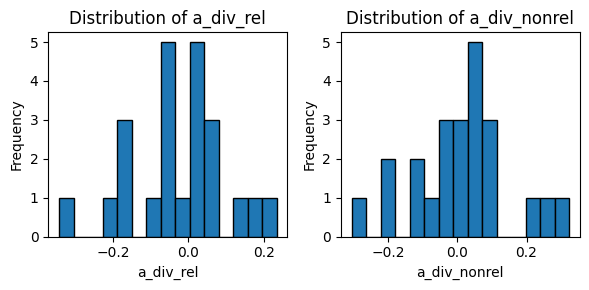

In [23]:
import pandas as pd

import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('/home/ia23938/Documents/GitHub/ValueSystemsAggregation/process_data/processed_data_ess.csv')

# Plot histograms for a_div_rel and a_div_nonrel
plt.figure(figsize=(6, 3))


plt.subplot(1, 2, 1)
plt.hist(data['a_div_rel'].dropna(), bins=15, edgecolor='black')
plt.title('Distribution of a_div_rel')
plt.xlabel('a_div_rel')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['a_div_nonrel'].dropna(), bins=15, edgecolor='black')
plt.title('Distribution of a_div_nonrel')
plt.xlabel('a_div_nonrel')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()